<a href="https://colab.research.google.com/github/cityu-assignment/CS3481-assignment2/blob/main/cs3481_asm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

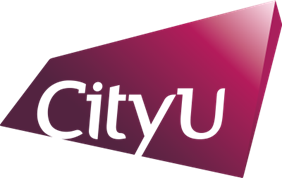

# **CS3481 Fundamentals of Data Science**

**Student Name: Lee Chak Kei**

**Student ID: 56682401**

# Import library

Importing necessary libraries then checks if the code is running in Google Colab and installs dtreeviz package silently, if it is.

In [119]:
import numpy as np 
import pandas as pd
import sklearn.tree as tree
import graphviz 
import sys
import matplotlib.pyplot as plt
import seaborn as sns

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

import dtreeviz.trees

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from yellowbrick.model_selection.importances import FeatureImportances
from matplotlib.pyplot import figure
from sklearn.inspection import permutation_importance

# Data Processing

The code loads a dataset file column_3C_weka.arff using arff.loadarff() function from scipy.io module, and creates a Pandas DataFrame from the data.

In [120]:
from scipy.io import arff

data = arff.loadarff("/content/column_3C_weka.arff")
df = pd.DataFrame(data[0])
df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,b'Hernia'
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,b'Hernia'
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,b'Hernia'
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,b'Hernia'
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,b'Hernia'
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,b'Normal'
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,b'Normal'
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,b'Normal'
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,b'Normal'


The code converts the data type of the 'class' column to string, and removes the first character ('b') of each element of the column (b'Hernia').

In [121]:
df['class'] = df['class'].astype('string')
df['class'] = [i[1:] for i in df['class']]
df['class']

0      'Hernia'
1      'Hernia'
2      'Hernia'
3      'Hernia'
4      'Hernia'
         ...   
305    'Normal'
306    'Normal'
307    'Normal'
308    'Normal'
309    'Normal'
Name: class, Length: 310, dtype: object

In [122]:
columns = df.iloc[:,:6].columns

The code selects the first 6 columns of the DataFrame as the feature matrix X.

In [123]:
X = df.iloc[:,:6].values
X[0:5]

array([[ 63.0278175 ,  22.55258597,  39.60911701,  40.47523153,
         98.67291675,  -0.25439999],
       [ 39.05695098,  10.06099147,  25.01537822,  28.99595951,
        114.4054254 ,   4.56425864],
       [ 68.83202098,  22.21848205,  50.09219357,  46.61353893,
        105.9851355 ,  -3.53031731],
       [ 69.29700807,  24.65287791,  44.31123813,  44.64413017,
        101.8684951 ,  11.21152344],
       [ 49.71285934,   9.65207488,  28.317406  ,  40.06078446,
        108.1687249 ,   7.91850062]])

Converts the categorical target variable 'class' to numerical using LabelEncoder() function from sklearn.preprocessing module. The transformed 'class' data is stored in y.

In [124]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df['class'])
y = label_encoder.transform(df['class'])

# Global Variable

In [125]:
model_list = []

# Def Function

In [126]:
def constructRandomForestClassifiers(selected_Criterion):
  random_forest_iterator = [i for i in range(1, 81)]

  train_errors = []
  test_errors = [] 
  loss_errors = []

  for i in random_forest_iterator:
      dtc = RandomForestClassifier(n_estimators = i,
                                   criterion=selected_Criterion,
                                   random_state=0
                                   )
      
      dtc.fit(X_trainset, y_trainset)
      
      trainAcc, testAcc, loss = printAcc(i, dtc)

      train_errors.append(trainAcc)
      test_errors.append(testAcc)
      loss_errors.append(loss)
    
  plotTreeTrainTest(random_forest_iterator, train_errors, test_errors)
  plotTreeLoss(random_forest_iterator, loss_errors)

In [127]:
def compareModel():
  log_cols=["Classifier", "Accuracy", "Log Loss"]
  log = pd.DataFrame(columns=log_cols)

  for i in range(0, len(model_list)):
    clf = model_list[i]
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    trainAcc, testAcc, loss = printAcc(i, clf)

    predTree = clf.predict(X_testset)
    plotConfusionMatrix(predTree)
    
    log_entry = pd.DataFrame([[name, testAcc*100, loss]], columns=log_cols)
    log = log.append(log_entry)

  print("="*30)

  sns.set_color_codes("muted")
  sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

  plt.xlabel('Accuracy %')
  plt.title('Classifier Accuracy')
  plt.show()

  sns.set_color_codes("muted")
  sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

  plt.xlabel('Log Loss')
  plt.title('Classifier Log Loss')
  plt.show()

In [128]:
def printAcc(i, tree): 
  train_z = tree.predict(X_trainset)
  test_z = tree.predict(X_testset)

  train_acc = accuracy_score(y_trainset, train_z)
  test_acc = accuracy_score(y_testset, test_z)
  loss = log_loss(y_testset, tree.predict_proba(X_testset))

  print('>%d, train: %.3f, test: %.3f, loss: %.5f' % (i, train_acc, test_acc, loss))

  return train_acc, test_acc, loss

In [129]:
def plotTreeTrainTest(iterator, train_errors, test_errors):
  plt.plot(iterator, train_errors, '-o', label='Train') 
  plt.plot(iterator, test_errors, '-o', label='Test') 
  plt.ylabel('Accuracy')
  plt.xlabel('n_estimators')
  plt.legend() 
  plt.show() 

In [130]:
def plotTreeLoss(iterator, loss_errors):
  plt.plot(iterator, loss_errors, label='Loss')
  plt.ylabel('Loss')
  plt.xlabel('Maximum Depth')
  plt.legend() 
  plt.show() 

In [131]:
def plotFeatureImportance(clf):
  name = clf.__class__.__name__
  feat_importances = pd.Series(clf.feature_importances_, index = columns).sort_values(ascending = True)
  print(feat_importances)

  plt.ylabel('Features')
  plt.xlabel('Mean decrease in impurity')
  plt.title(name)

  feat_importances.plot(kind = 'barh')

In [132]:
def plotPermutationImportance(clf):
  name = clf.__class__.__name__
  perm_importance = permutation_importance(clf, X_testset, y_testset)
  sorted_idx = perm_importance.importances_mean.argsort()
  print(perm_importance)

  plt.ylabel('Features')
  plt.xlabel("Permutation Importance")
  plt.title(name)
  plt.barh(columns[sorted_idx], perm_importance.importances_mean[sorted_idx])

In [133]:
def plotConfusionMatrix(predTree):
  cm = confusion_matrix(y_testset, predTree)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_encoder.classes_))                        
  print(cm)

  ax = plt.figure().subplots()
  ax.grid(False)
  disp.plot(ax = ax)
  plt.show()

# Specific training set/test set partition

In [134]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

`test_size` parameter is set to `0.3`, which means that the testing set will contain 30% of the data, and the training set will contain the remaining 70%.

`stratify=y` is used to ensure that the class distribution in the original dataset is maintained in both the training and testing sets. It is useful when dealing with imbalanced datasets where the target variable has unequal class distributions.

`random_state=0` is used to set a fixed seed for the random number generator. This ensures that each time the code is run with the same input data, the same random samples are selected for the training and testing sets. This is important for reproducibility of results, as different random splits can lead to different model performance.

# Construct Random Forest Models

The function constructRandomForestClassifiers(selected_Criterion) is then defined to analyze multiple random forest model with test 0.3 splits. It uses the RandomForestClassifier function from sklearn.tree to construct a random forest model with a given criterion (entropy or gini) and random state. 

The constructRandomForestClassifiers function is called twice: once with selected_Criterion set to `entropy` and once with selected_Criterion set to `gini`.



## **Compare decision trees**


### **If criterion is entropy**



>1, train: 0.912, test: 0.796, loss: 7.36376
>2, train: 0.894, test: 0.742, loss: 2.93656
>3, train: 0.963, test: 0.849, loss: 1.80791
>4, train: 0.968, test: 0.828, loss: 1.44563
>5, train: 0.977, test: 0.806, loss: 1.10983
>6, train: 0.991, test: 0.817, loss: 1.07580
>7, train: 0.986, test: 0.806, loss: 1.07469
>8, train: 0.995, test: 0.849, loss: 0.70148
>9, train: 0.995, test: 0.860, loss: 0.69575
>10, train: 0.995, test: 0.839, loss: 0.69999
>11, train: 0.995, test: 0.849, loss: 0.70605
>12, train: 1.000, test: 0.849, loss: 0.69482
>13, train: 0.995, test: 0.849, loss: 0.68634
>14, train: 0.995, test: 0.860, loss: 0.67887
>15, train: 0.995, test: 0.839, loss: 0.68290
>16, train: 1.000, test: 0.828, loss: 0.68838
>17, train: 1.000, test: 0.839, loss: 0.68520
>18, train: 1.000, test: 0.828, loss: 0.33393
>19, train: 1.000, test: 0.828, loss: 0.34074
>20, train: 1.000, test: 0.828, loss: 0.33857
>21, train: 1.000, test: 0.860, loss: 0.33662
>22, train: 1.000, test: 0.828, loss: 0.334

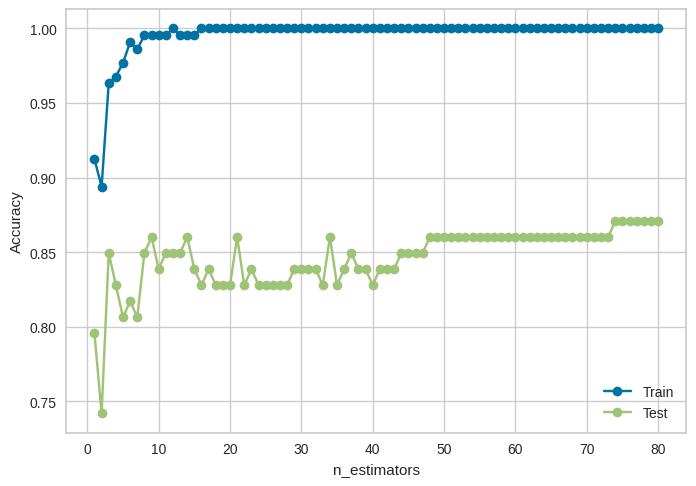

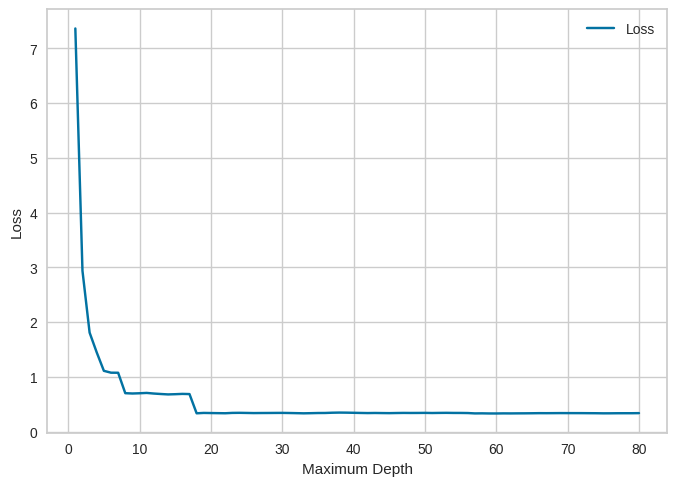

In [135]:
constructRandomForestClassifiers('entropy')

The random forest model using entropy as the splitting criterion has a high training accuracy of over 90%, but its testing accuracy is only around 80%, indicating that it might be overfitting the training data.

We can see that the testing accuracy initially starts off low but then gradually improves as the model is trained. However, after around 18 `n_estimators`, the testing accuracy plateaus and does not improve much further despite the training accuracy continuing to increase.

To address the issue of overfitting, we could try reducing the complexity of the model by limiting the number of trees or reducing the maximum depth of each tree.

Alternatively, we could also try using a different splitting criterion such as Gini impurity, which might help improve the testing accuracy of the model.






### **If criterion is gini**



>1, train: 0.917, test: 0.828, loss: 6.20106
>2, train: 0.912, test: 0.774, loss: 3.67443
>3, train: 0.968, test: 0.806, loss: 1.83955
>4, train: 0.977, test: 0.806, loss: 1.12823
>5, train: 0.991, test: 0.828, loss: 1.12252
>6, train: 0.986, test: 0.839, loss: 0.70985
>7, train: 0.986, test: 0.849, loss: 0.71266
>8, train: 0.986, test: 0.849, loss: 0.70762
>9, train: 0.986, test: 0.860, loss: 0.70884
>10, train: 0.995, test: 0.860, loss: 0.69305
>11, train: 0.986, test: 0.860, loss: 0.69023
>12, train: 0.995, test: 0.871, loss: 0.68520
>13, train: 0.991, test: 0.860, loss: 0.67897
>14, train: 0.995, test: 0.871, loss: 0.68047
>15, train: 0.995, test: 0.871, loss: 0.68683
>16, train: 1.000, test: 0.860, loss: 0.68963
>17, train: 1.000, test: 0.871, loss: 0.69005
>18, train: 1.000, test: 0.871, loss: 0.32952
>19, train: 1.000, test: 0.871, loss: 0.33273
>20, train: 1.000, test: 0.871, loss: 0.33210
>21, train: 1.000, test: 0.871, loss: 0.32831
>22, train: 1.000, test: 0.860, loss: 0.322

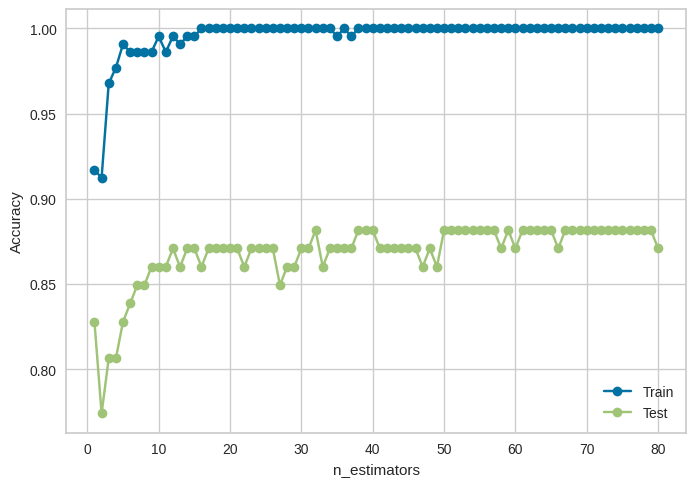

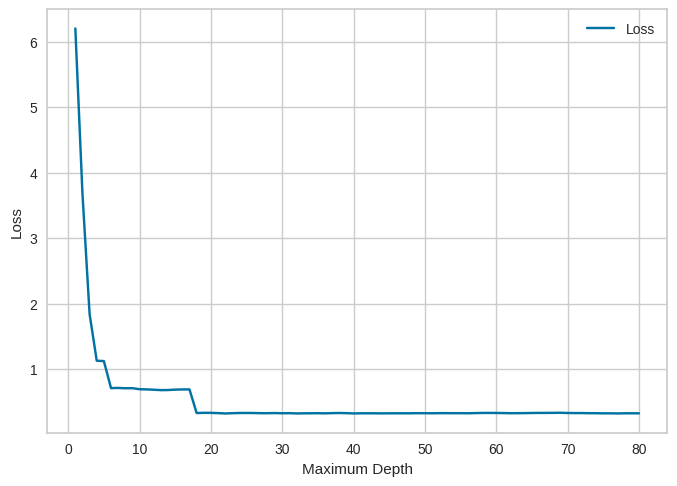

In [136]:
constructRandomForestClassifiers('gini')

We can see that the model's test performance (accuracy) is lower when using the entropy criterion compared to the Gini criterion.

In the first model using Gini, the test accuracy starts at 0.828 and steadily increases to 0.882 by the 38th `n_estimators` before hovering around that value for the rest of the training. On the other hand, when using entropy, the test accuracy starts at 0.796 and fluctuates without any significant improvement throughout the training, hovering around 0.830-0.871.

Therefore, based on this comparison, we can conclude that the Gini criterion is better suited for this particular problem and dataset, as it produces a more accurate model compared to entropy.

# Analysis selected Random Forest Model

### **Train the selected Random Forest Model**

>gini 32, train: 1.000, test: 0.882, loss: 0.32332

The best performing model would be the one with the highest test accuracy score. In this case, it appears that `gini` model 32 has the highest test accuracy score of 0.882, which is tied with models 38 and 40.

Then defines `n_estimators` and `selected_criterion` variables and uses them to train a single random forest model with a given criterion.

In [137]:
n_estimators = 32
selected_criterion = 'gini'

In [138]:
clf = RandomForestClassifier(n_estimators = n_estimators,
                             criterion=selected_criterion,
                             random_state=0
                            )

clf.fit(X_trainset, y_trainset)
printAcc(n_estimators, clf)
model_list.append(clf)

>32, train: 1.000, test: 0.882, loss: 0.32332


# Compare different component decision trees in the model

>0, train: 0.917, test: 0.828, loss: 6.20106
>1, train: 0.871, test: 0.710, loss: 10.46429
>2, train: 0.908, test: 0.742, loss: 9.30159
>3, train: 0.903, test: 0.688, loss: 11.23942
>4, train: 0.931, test: 0.753, loss: 8.91402
>5, train: 0.903, test: 0.839, loss: 5.81349
>6, train: 0.899, test: 0.774, loss: 8.13889
>7, train: 0.926, test: 0.796, loss: 7.36376
>8, train: 0.926, test: 0.753, loss: 8.91402
>9, train: 0.922, test: 0.849, loss: 5.42593
>10, train: 0.894, test: 0.796, loss: 7.36376
>11, train: 0.922, test: 0.806, loss: 6.97619
>12, train: 0.912, test: 0.849, loss: 5.42593
>13, train: 0.926, test: 0.785, loss: 7.75132
>14, train: 0.908, test: 0.731, loss: 9.68915
>15, train: 0.903, test: 0.785, loss: 7.75132
>16, train: 0.940, test: 0.796, loss: 7.36376
>17, train: 0.885, test: 0.742, loss: 9.30159
>18, train: 0.899, test: 0.774, loss: 8.13889
>19, train: 0.949, test: 0.796, loss: 7.36376
>20, train: 0.876, test: 0.839, loss: 5.81349
>21, train: 0.908, test: 0.828, loss: 6.20

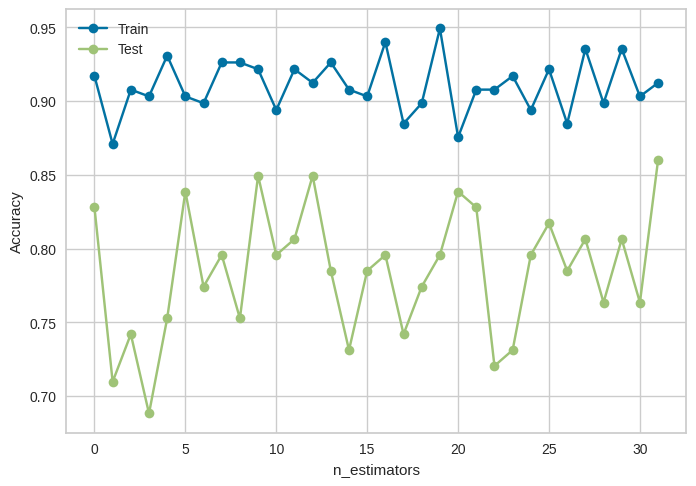

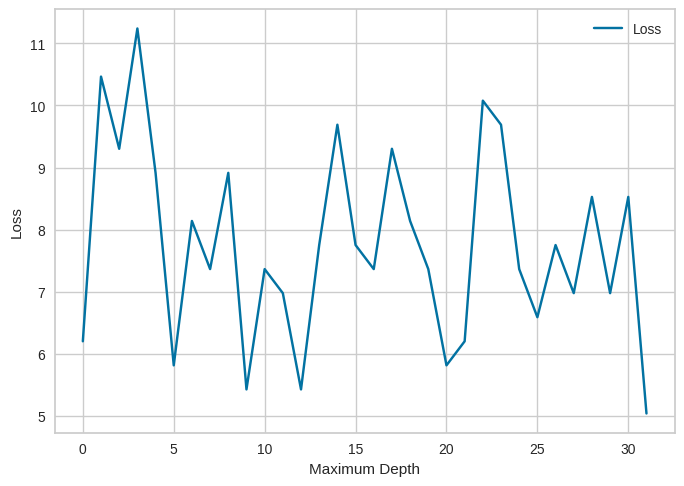

In [139]:
componentTree_iterator = [i for i in range(0, n_estimators)]

train_errors = []
test_errors = [] 
loss_errors = []

for i in componentTree_iterator:
  componentTree = clf.estimators_[i]

  trainAcc, testAcc, loss = printAcc(i, componentTree)

  train_errors.append(trainAcc)
  test_errors.append(testAcc)
  loss_errors.append(loss)
    
plotTreeTrainTest(componentTree_iterator, train_errors, test_errors)
plotTreeLoss(componentTree_iterator, loss_errors)

From the given results, it is observed that as the number of decision trees in the Gini random forest model increases, the training accuracy increases almost consistently. However, the test accuracy shows fluctuations.

Initially, with one decision tree, the model has a lower accuracy of 0.710 on the test set. As more decision trees are added, the accuracy improves, reaching a maximum of 0.860 with 31 decision trees.

However, after a certain point, increasing the number of decision trees causes overfitting, leading to a decrease in the test accuracy. This is evident from the fluctuations in the test accuracy observed from the 5th decision tree onwards.

It is also observed that the model tends to overfit after a certain number of decision trees, as the training accuracy continues to increase while the test accuracy decreases.

Overall, the best test accuracy of 0.860 is achieved with 31 decision trees in the Gini random forest model.

In [140]:
componentTree = clf.estimators_[31]

model_list.append(componentTree)

# Compare Random Forest Model and Component Tree

To compare the classification performance of the individual decision trees with the original Gini Random Forest model, we need to evaluate the overall performance of the Random Forest model.

The original Gini Random Forest model achieved a test accuracy of 0.882, which is higher than the individual decision trees' test accuracies. However, the performance of the individual decision trees varies, with some achieving test accuracies higher than others. 

>31, train: 0.912, test: 0.860, loss: 5.03836

For example, decision tree number 31 achieved a test accuracy of 0.860, which is higher than some other decision trees and closer to the overall test accuracy of the Random Forest model.


RandomForestClassifier
>0, train: 1.000, test: 0.882, loss: 0.32332
[[12  6  0]
 [ 2 27  1]
 [ 0  2 43]]


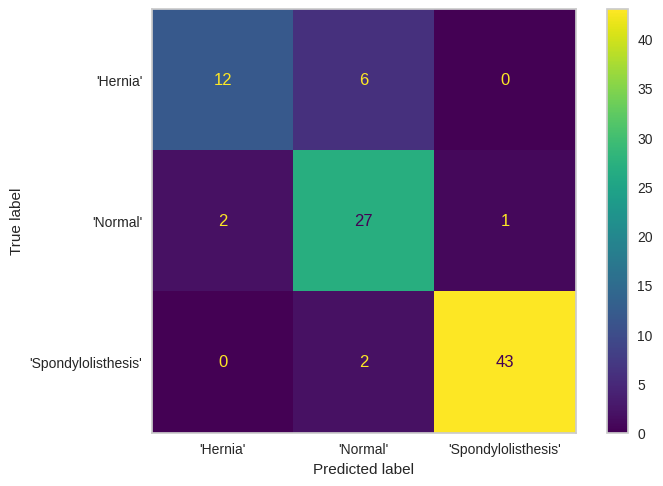

<ipython-input-127-4fa72942b16d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


DecisionTreeClassifier
>1, train: 0.912, test: 0.860, loss: 5.03836
[[10  8  0]
 [ 2 26  2]
 [ 0  1 44]]


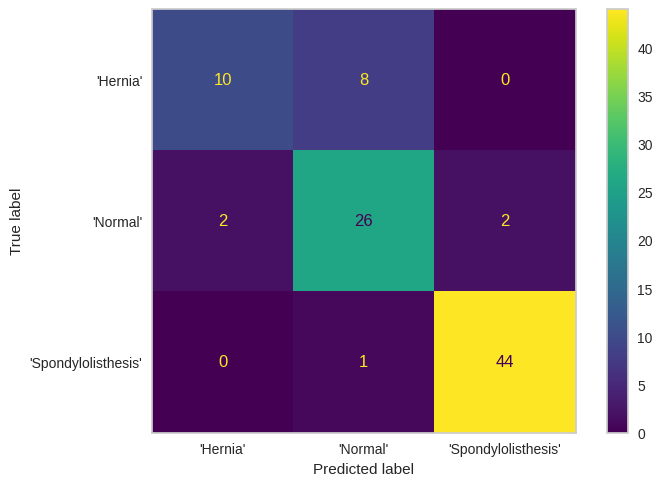

<ipython-input-127-4fa72942b16d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


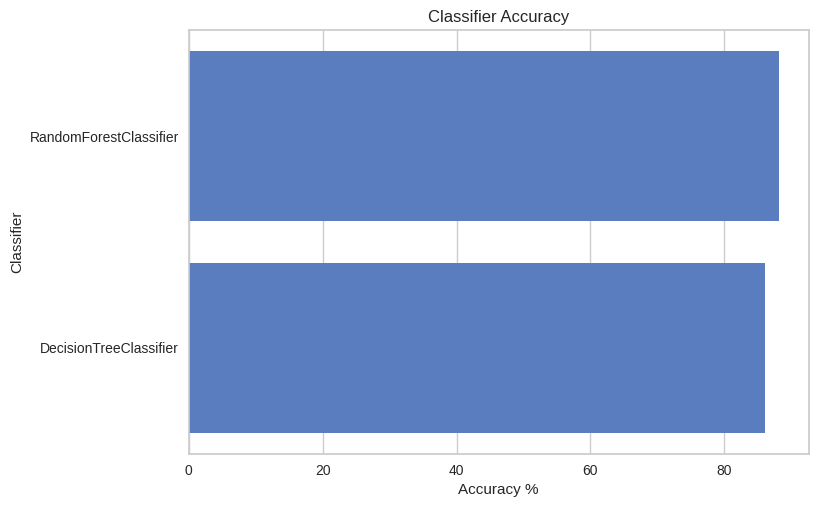

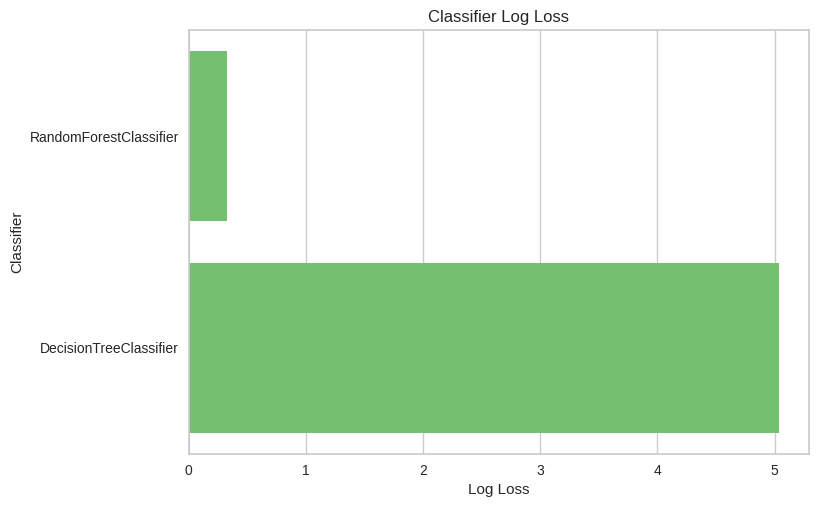

In [141]:
compareModel()

The RandomForestClassifier has a higher classification performance than the DecisionTreeClassifier. The RandomForestClassifier has a training accuracy of 1.0 and a testing accuracy of 0.882, while the DecisionTreeClassifier has a training accuracy of 0.912 and a testing accuracy of 0.86.

The confusion matrix for the RandomForestClassifier shows that it correctly classified 82 out of 93 test instances, misclassifying only 11 instances. On the other hand, the confusion matrix for the DecisionTreeClassifier shows that it correctly classified 80 out of 93 test instances, misclassifying 13 instances.

Additionally, RandomForestClassifier achieved a low log loss value of 0.32332, which means that the predicted probabilities for the classes were close to the actual probabilities. However, DecisionTreeClassifier had a much higher log loss value of 5.03836, which suggests that its predicted probabilities for the classes were much farther from the actual probabilities. This indicates that the model may have overfitted the training data.

Overall, the RandomForestClassifier has a higher accuracy and better performance than the DecisionTreeClassifier.

## Importance of Features in Model

Permutation Importance and Feature Importance will be used in this part. Both methods can be used to estimate feature importance, they have some differences. One advantage of Permutation Importance is that it is more robust to correlated features, as it evaluates the importance of each feature in isolation. Feature Importance, on the other hand, may overestimate the importance of correlated features if they are included in the same decision split.

Another difference is that Permutation Importance can be used with any type of model, while Feature Importance is specific to certain models, such as decision tree-based models.

### Feature Importance

pelvic_tilt                 0.097157
pelvic_radius               0.105570
lumbar_lordosis_angle       0.110997
pelvic_incidence            0.113793
sacral_slope                0.140568
degree_spondylolisthesis    0.431914
dtype: float64


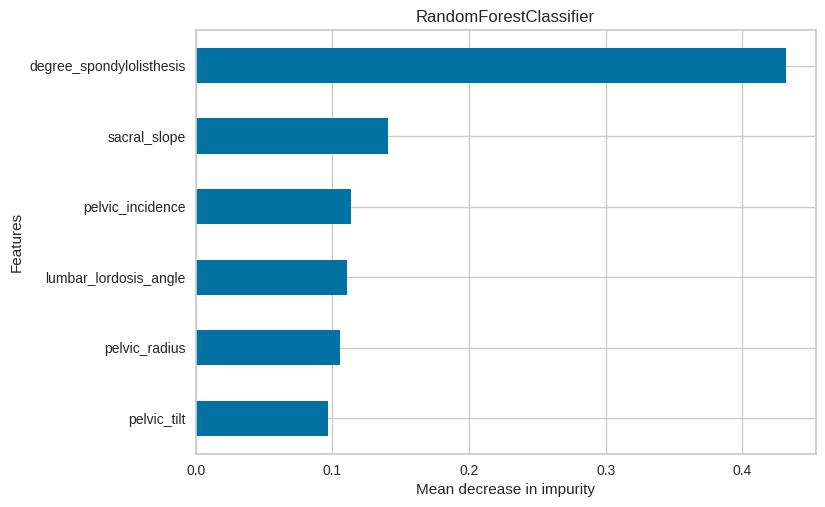

In [142]:
plotFeatureImportance(clf)

pelvic_incidence            0.064032
sacral_slope                0.111053
pelvic_tilt                 0.116630
pelvic_radius               0.126749
lumbar_lordosis_angle       0.284490
degree_spondylolisthesis    0.297046
dtype: float64


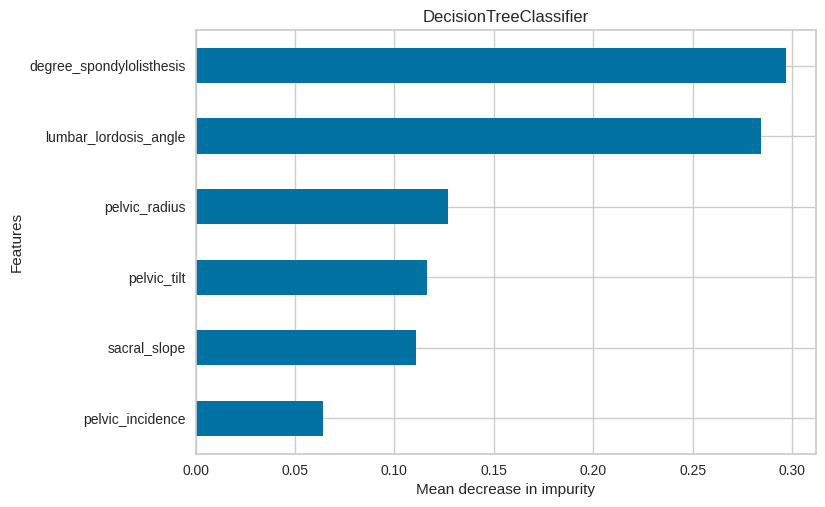

In [143]:
plotFeatureImportance(componentTree)

The feature importance lists for the RandomForestClassifier `clf` and DecisionTreeClassifier `componentTree` models are different.

In the RandomForestClassifier model, the degree_spondylolisthesis feature has the highest importance (0.431914), followed by sacral_slope (0.140568), and pelvic_incidence (0.113793). In contrast, the DecisionTreeClassifier model considers the lumbar_lordosis_angle feature as the most important one (0.284490), followed by degree_spondylolisthesis (0.297046) and pelvic_radius (0.126749).

Both models seem to agree that the degree_spondylolisthesis feature is one of the most important features in determining the presence of abnormal spinal conditions. However, the RandomForestClassifier model places more importance on sacral_slope and pelvic_incidence, while the DecisionTreeClassifier model considers lumbar_lordosis_angle and pelvic_radius to be more important.

### Permutation Importance

{'importances_mean': array([0.0172043 , 0.04301075, 0.06021505, 0.09247312, 0.06451613,
       0.44516129]), 'importances_std': array([0.01458566, 0.01360119, 0.02214114, 0.01096563, 0.02040179,
       0.02507936]), 'importances': array([[0.        , 0.03225806, 0.02150538, 0.03225806, 0.        ],
       [0.02150538, 0.06451613, 0.04301075, 0.04301075, 0.04301075],
       [0.08602151, 0.07526882, 0.02150538, 0.05376344, 0.06451613],
       [0.09677419, 0.07526882, 0.08602151, 0.09677419, 0.10752688],
       [0.06451613, 0.08602151, 0.05376344, 0.03225806, 0.08602151],
       [0.46236559, 0.44086022, 0.41935484, 0.48387097, 0.41935484]])}


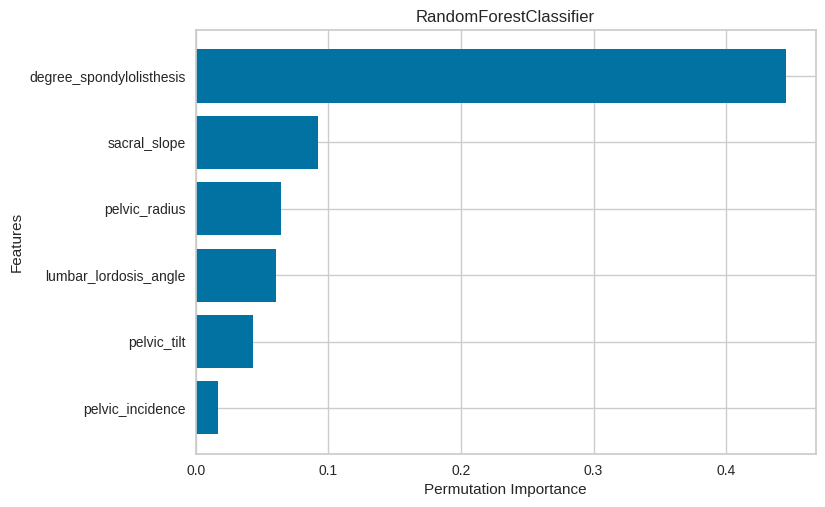

In [144]:
plotPermutationImportance(clf)

{'importances_mean': array([0.04086022, 0.04731183, 0.13333333, 0.00860215, 0.04086022,
       0.26451613]), 'importances_std': array([0.00804658, 0.01747105, 0.02107088, 0.01849962, 0.02489427,
       0.03882897]), 'importances': array([[ 0.05376344,  0.04301075,  0.03225806,  0.03225806,  0.04301075],
       [ 0.04301075,  0.04301075,  0.02150538,  0.07526882,  0.05376344],
       [ 0.13978495,  0.12903226,  0.09677419,  0.16129032,  0.13978495],
       [ 0.        ,  0.04301075,  0.01075269,  0.        , -0.01075269],
       [ 0.04301075,  0.        ,  0.05376344,  0.07526882,  0.03225806],
       [ 0.25806452,  0.21505376,  0.2688172 ,  0.24731183,  0.33333333]])}


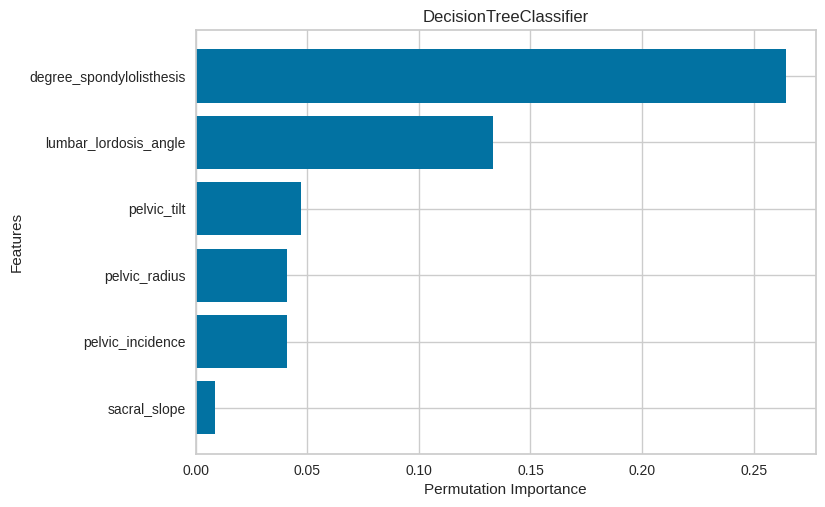

In [145]:
plotPermutationImportance(componentTree)

For the RandomForestClassifier model, both the Feature Importance and Permutation Importance lists indicate that the most important attribute is `degree_spondylolisthesis`, followed by `sacral_slope`, `lumbar_lordosis_angle`, `pelvic_incidence`, `pelvic_radius`, and `pelvic_tilt`. However, the relative importance values in the Feature Importance list are different from those in the Permutation Importance list.

For the DecisionTreeClassifier model, the Feature Importance list shows that `lumbar_lordosis_angle` and `degree_spondylolisthesis` are the most important attributes, followed by `pelvic_radius`, `pelvic_tilt`, `sacral_slope`, and `pelvic_incidence`. On the other hand, the Permutation Importance list indicates that `lumbar_lordosis_angle` and `degree_spondylolisthesis` are still the most important attributes, but `pelvic_tilt` and `sacral_slope` are also relatively important.

Overall, both models identify `degree_spondylolisthesis` as the most important attribute, but there are some differences in the relative importance of the other attributes. It's also worth noting that the Permutation Importance values may be more reliable as they are based on the actual impact of randomly permuting the values of each attribute on the model's performance.

# Construct Naïve Bayes classifier model

In [146]:
nb = GaussianNB() 
nb.fit(X_trainset, y_trainset)
printAcc(0, nb)

model_list.append(nb)

>0, train: 0.829, test: 0.860, loss: 0.51885


# Compare All Model

RandomForestClassifier
>0, train: 1.000, test: 0.882, loss: 0.32332
[[12  6  0]
 [ 2 27  1]
 [ 0  2 43]]


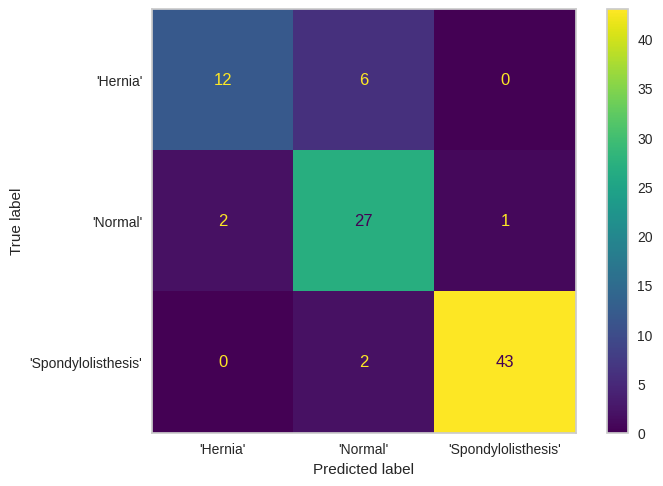

<ipython-input-127-4fa72942b16d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


DecisionTreeClassifier
>1, train: 0.912, test: 0.860, loss: 5.03836
[[10  8  0]
 [ 2 26  2]
 [ 0  1 44]]


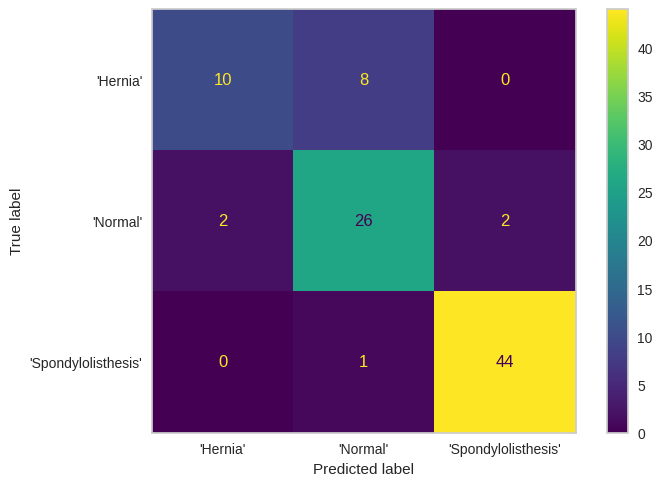

<ipython-input-127-4fa72942b16d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


GaussianNB
>2, train: 0.829, test: 0.860, loss: 0.51885
[[13  4  1]
 [ 5 23  2]
 [ 0  1 44]]


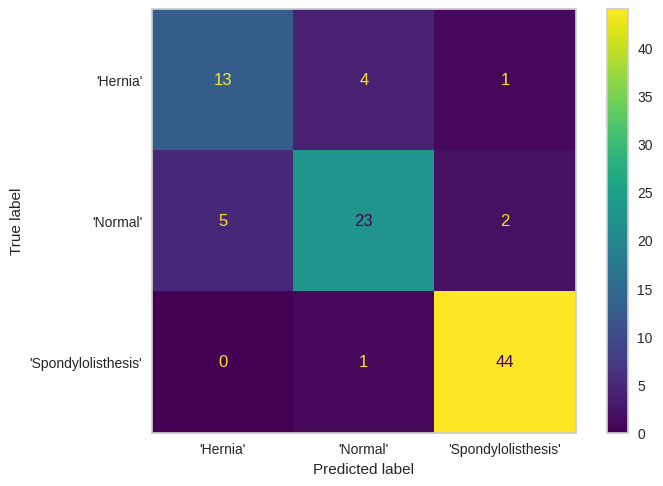

<ipython-input-127-4fa72942b16d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


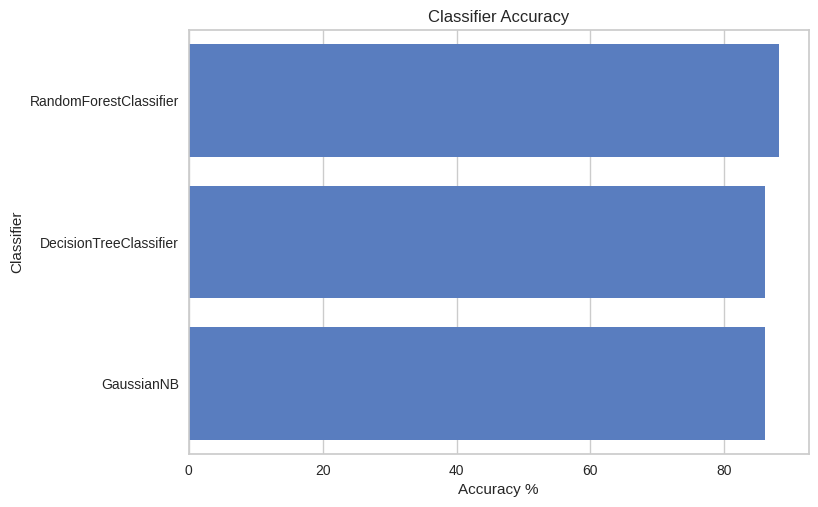

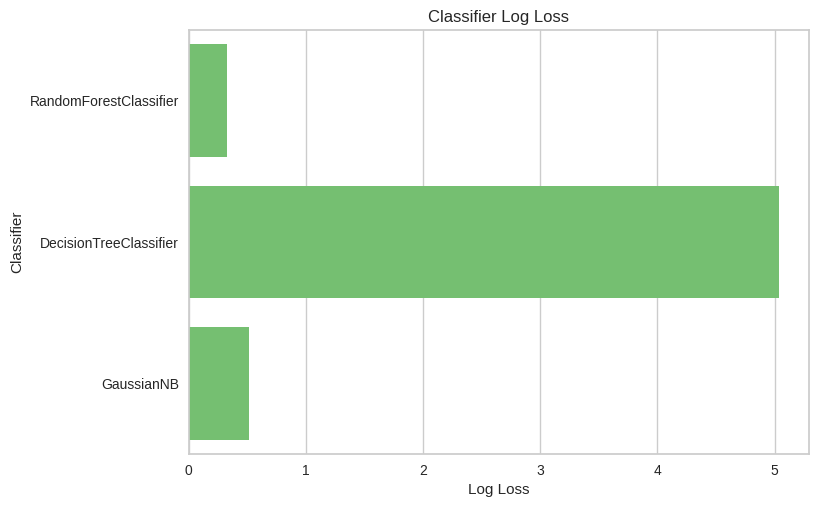

In [147]:
compareModel()

I have trained and tested three different classification models: RandomForestClassifier, DecisionTreeClassifier, and GaussianNB.

RandomForestClassifier had the highest accuracy of 0.882 on the test set and also the lowest loss value of 0.32332. The confusion matrix showed that there were 12 true positive predictions for the first class, 27 true positive predictions for the second class, and 43 true positive predictions for the third class.

DecisionTreeClassifier had an accuracy of 0.860 on the test set and a loss value of 5.03836. The confusion matrix showed that there were 10 true positive predictions for the first class, 26 true positive predictions for the second class, and 44 true positive predictions for the third class.

The GaussianNB classifier achieved an accuracy score of 0.86, which is the same as the DecisionTreeClassifier. However, it had a higher log loss value of 0.51885 compared to the RandomForestClassifier. The confusion matrix showed that there were 13 true positive predictions for the first class, 23 true positive predictions for the second class, and 44 true positive predictions for the third class. This indicates that the model's predicted probabilities were less accurate and farther from the actual probabilities than those of the RandomForestClassifier.

Based on the evaluation metrics used, the RandomForestClassifier performed the best among the three models, achieving both high accuracy and low log loss values. The DecisionTreeClassifier achieved a lower accuracy score and much higher log loss value, indicating possible overfitting. The GaussianNB classifier achieved the same accuracy score as the DecisionTreeClassifier, but had a higher log loss value, indicating less accurate probability predictions.